# 1- Import Libraries

In [4]:
import os
import gc
import PIL
import cv2
import uuid
import shutil
import glob as gb
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
%matplotlib inline


import keras
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

# 2- Loading DataSet

> ------

> #### We have 6 Files csv


In [ ]:
rm -rf /content/csv

In [5]:
# prompt: import from kaggle

!pip install kaggle

# Assuming you have your kaggle.json in the correct location (~/.kaggle/kaggle.json)
# If not, upload it:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (replace with the actual Kaggle dataset URL)
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset





Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0


In [6]:
# Unzip the dataset
!unzip cbis-ddsm-breast-cancer-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/1-013.jpg  
  inflating: jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/2-012.jpg  

In [7]:


import kaggle

# Download the dataset
!kaggle datasets download -d hayder17/breast-cancer-detection

# Unzip the dataset
!unzip breast-cancer-detection.zip




Dataset URL: https://www.kaggle.com/datasets/hayder17/breast-cancer-detection
License(s): DbCL-1.0
Archive:  breast-cancer-detection.zip
  inflating: test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg  
  inflating: test/0/1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg  
  inflating: test/0/1588_274144628_png.rf.58cbfa689d58bca33eb53a98e2a44cb1.jpg  
  inflating: test/0/1601_364263039_png.rf.8a3b35c9dad8729063a9d9ab60fe3c1a.jpg  
  inflating: test/0/1601_751935569_png.rf.6f6ec0c9f80d50a36684d99c4bee20d0.jpg  
  inflating: test/0/1607_1416980837_png.rf.8552d91ecac36ed533f1a2a53ca77740.jpg  
  inflating: test/0/1638_1923297632_png.rf.ac117130fda038f0ce846f93eb001779.jpg  
  inflating: test/0/1649_1117924917_png.rf.8256b936a9d187da0807adc99545ee08.jpg  
  inflating: test/0/1649_428595380_png.rf.67c04778f1beca13be9fc29331df8b40.jpg  
  inflating: test/0/1657_2120850106_png.rf.2436bb2abb4f49855f5d507e3b638975.jpg  
  inflating: test/0/1688_550590619_png.rf.a04a2c

# 3- Data Preparation

In [8]:
dicom_df = pd.read_csv("/content/csv/dicom_info.csv")

> # check image path in dataset

> ------


> #### cropped images

In [9]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
cropped_images.head()

,image_path
0,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...


> ------

> #### full mammogram images

In [10]:
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
full_mammogram.head()

,image_path
1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...


> ------

> #### ROI images

In [11]:
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path
roi_mask.head()

,image_path
5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...


In [12]:
# # delete dicom_df after finished use it
del dicom_df
gc.collect()

4

> # change directory path of images

> ------

> #### Correct Path

In [13]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [14]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [15]:
correct_dir = "/content/jpeg"

In [16]:
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

Cropped Images paths:
/content/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [17]:
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])


Full mammo Images paths:
/content/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [18]:
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


ROI Mask Images paths:
/content/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


> # organize image paths

>> ---

>> By get image file name

In [ ]:
def get_image_file_name(data, new_dict):
    """
   
    /input
    /cbis-ddsm-breast-cancer-image-dataset
    /jpeg
    /1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304 [5]
    /1-172.jpg

    """
    for dicom in data:
        key = dicom.split('/')[-2]
#         print(key)
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [20]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


> ------

> #### View keys

In [21]:
del cropped_images, full_mammogram, roi_mask
gc.collect()

0

> ------

> # fix image paths

In [22]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):
#         print(f"Image Path: {image[11]}")

        img_name = image[11].split('/')[2]
#         print(f"Looking for key: {img_name}")  # Debugging step

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
#             print(f"KeyError: '{img_name}' not found in full_mammo_dict")  # Debugging step

        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 12] = None
#             print(f"KeyError: '{img_name}' not found in cropped_images_dict")  # Debugging step

> ------

> # load the mass dataset

In [23]:
mass_train = pd.read_csv("/content/csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv("/content/csv/mass_case_description_test_set.csv")

> ------

> #### apply to datasets

In [24]:
fix_image_path(mass_train)

> ------

> #### rename columns

In [25]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})


> ------

> #### view mass_test

In [26]:
fix_image_path(mass_test)

> ------

> #### # rename columns

In [27]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})



> -------

> #### check datasets shape

In [28]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


> ------

> # load the calc dataset

In [29]:
calc_train = pd.read_csv("/content/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv("/content/csv/calc_case_description_test_set.csv")

> --------

> #### Rename Columns

In [30]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})


In [31]:
fix_image_path(calc_train)

> --------

> #### Rename Columns

In [32]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})


In [33]:
fix_image_path(calc_test)

In [34]:
print(f'Shape of mass_train: {calc_train.shape}')
print(f'Shape of mass_test: {calc_test.shape}')

Shape of mass_train: (1546, 14)
Shape of mass_test: (326, 14)


> ------

> ## Merge datasets

In [35]:
full_dataset = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)

In [36]:
del mass_train, mass_test, calc_train, calc_test
gc.collect()

0

* > ## Create a binary mapper

In [37]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

> ## Define the target size

In [38]:
target_size = (224, 224, 3)

In [39]:
# Apply class mapper to pathology column
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

<ipython-input-39-88e61f5e36a7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


* > ## Check the number of classes

In [40]:
num_classes = len(full_dataset['labels'].unique())

In [41]:
del full_dataset
gc.collect()

0

In [42]:
class_names = ['Benign', 'Malignant']

In [43]:
# # Check the distribution of labels
# label_counts = full_dataset['labels'].value_counts()
# print(label_counts)

In [ ]:


# Path to the working directory
dir_path = '/content/working/'

# # Loop through all files and subdirectories in the working directory
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symbolic link
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove the directory and its contents
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("All files and subdirectories in '/content/working' have been removed.")


All files and subdirectories in '/content/working' have been removed.


In [46]:
def copy_images_with_unique_filenames(source_images, source_labels, destination_dir):
    """
    Copy images from source to destination_dir in subfolders '0' and '1', ensuring unique filenames.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Create the destination subfolders '0' and '1'
    category_dest_dir_zero = os.path.join(destination_dir, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination_dir, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    # Copy all images to the appropriate folder based on the label
    for idx, (source, label) in enumerate(zip(source_images, source_labels)):
        if os.path.exists(source):
            try:
                # Generate a unique filename
                filename = os.path.basename(source)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"

                if label == 0:
                    shutil.copy(source, os.path.join(category_dest_dir_zero, unique_filename))
                    benign_images += 1
                elif label == 1:
                    shutil.copy(source, os.path.join(category_dest_dir_one, unique_filename))
                    malignant_images += 1

#                 print(f"Copied image {idx + 1}/{len(source_images)} to class {label}")
            except Exception as e:
                print(f"Error copying image {source}: {e}")
                skipped_images.append(source)
        else:
            print(f"Image not found: {source}")
            skipped_images.append(source)

    # After running the function
    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)

In [47]:
print(f"Number of full_images: {len(full_images)}")
print(f"Sample path: {full_images[0]}")
print(f"File exists? {os.path.exists(full_images[0])}")


Number of full_images: 3286
Sample path: /content/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
File exists? True


In [48]:
# Example usage
destination_dir = "/content/working/merged_images"  # Update this path as needed

copy_images_with_unique_filenames(full_images, full_labels, destination_dir)


Copying complete.
Benign images copied (label 0): 1931
Malignant images copied (label 1): 1355
Total skipped images: 0


In [52]:
del full_images, full_labels
gc.collect()

0

 * > --------

> # Another DataSet

In [53]:
def copy_images_to_destination(source_dir, destination_dir):
    """
    Move or copy images from source_dir to destination_dir in subfolders '0' and '1'.
    """
    # Define the categories (class labels) as '0' and '1'
    categories = ['0', '1']

    for category in categories:
        # Create the destination subfolder (e.g., '0' or '1') if it doesn't exist
        category_dest_dir = os.path.join(destination_dir, category)
        os.makedirs(category_dest_dir, exist_ok=True)

        # Path to the current category folder in the source directory
        category_source_dir = os.path.join(source_dir, category)

        # Move or copy all images from the source category folder to the destination folder
        for img_name in os.listdir(category_source_dir):
            # Construct full file paths
            img_source_path = os.path.join(category_source_dir, img_name)
            img_dest_path = os.path.join(category_dest_dir, img_name)

            # Copy the image to the destination folder (you can use shutil.move to move instead of copy)
            shutil.copy(img_source_path, img_dest_path)

            # Optionally, print the status
#             print(f"Copied {img_source_path} to {img_dest_path}")

> **shutil.copy() vs shutil.move(): The script currently uses shutil.copy() to copy the images. If you want to move the images instead (which will remove them from the source directories), replace shutil.copy() with shutil.move().**

In [54]:
# Define the paths to your dataset folders
test = "/content/test"
train = "/content/train"
valid = "/content/valid"

# Destination directory for the unified dataset
destination_dir = "/content/working/merged_images"  # Update this path as needed

In [55]:
# Apply the function to each of the dataset folders (test, train, valid)
copy_images_to_destination(test, destination_dir)
copy_images_to_destination(train, destination_dir)
copy_images_to_destination(valid, destination_dir)

> # Compress New DataSet To Download It.

In [59]:
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    if image_path:
#         absolute_image_path = os.path.abspath(image_path)
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is None:
#             print(f"Warning: Failed to load image at {absolute_image_path}. Skipping this file.")
            return None

        # Resize the image and normalize it
        image = cv2.resize(image, (target_size[0], target_size[1]))
        image_array = image / 255.0  # Normalize the image to range [0, 1]
        return image_array
    else:
        return None

In [60]:
path_zero = '/content/working/merged_images/0'
path_one  = '/content/working/merged_images/1'

# Preprocess and collect images and labels
benign_images = np.array([image_processor(os.path.join(path_zero, x), (224, 224)) for x in os.listdir(path_zero)])
benign_labels = np.array([0] * len(benign_images))  # Label 0 for benign

malignant_images = np.array([image_processor(os.path.join(path_one, x), (224, 224)) for x in os.listdir(path_one)])
malignant_labels = np.array([1] * len(malignant_images))  # Label 1 for malignant

In [61]:
print(f"The Count of 0 is: {benign_images.shape}")
print()
print(f"The count of 0 label is: {benign_labels.shape}")
print()
print(f"The count of 1 is: {malignant_images.shape}")
print()
print(f"The count of 1 label is: {malignant_labels.shape}")

The Count of 0 is: (4156, 224, 224, 3)

The count of 0 label is: (4156,)

The count of 1 is: (2513, 224, 224, 3)

The count of 1 label is: (2513,)


In [62]:
diff_cases = max(len(benign_images), len(malignant_images)) - min(len(benign_images), len(malignant_images))

In [63]:
print(f"the difference is : {diff_cases}")

the difference is : 1643


In [64]:
datagen = ImageDataGenerator(rotation_range=25,     # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.3,      # Randomly zoom image
                             width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             fill_mode='nearest')

In [ ]:
# Augment the data and increase the dataset size
# Choose how many new samples you want to generate
augment_size = diff_cases  

augmented_images_iter = datagen.flow(malignant_images, malignant_labels, batch_size=64, shuffle=False)

augmented_images = []

# Get augmented images and labels
for sample in range(augment_size // 64):
    image_batch, _ = next(augmented_images_iter)
    for img in image_batch:  # Iterate through each image in the batch
        augmented_images.append(img)  # Append individual images to the list

augmented_images = np.array(augmented_images)

# Combine with original data
train_images_augmented = np.concatenate((malignant_images, augmented_images), axis=0)
train_labels_augmented = np.concatenate((np.full(len(malignant_images), 1), np.full(len(augmented_images), 1)), axis=0)

# Print the shape of the data before and after augmentation
print("Shape of malignant_images before augmentation:", malignant_images.shape)
print("Shape of train_labels before augmentation:", len(malignant_images))
print("Shape of train_images after augmentation:", train_images_augmented.shape)
print("Shape of train_labels after augmentation:", train_labels_augmented.shape)

Shape of malignant_images before augmentation: (2513, 224, 224, 3)
Shape of train_labels before augmentation: 2513
Shape of train_images after augmentation: (4113, 224, 224, 3)
Shape of train_labels after augmentation: (4113,)


In [66]:
del augmented_images_iter, augment_size, augmented_images

In [67]:
# # Remove None values (in case some images failed to load)
# benign_images = [img for img in benign_images if img is not None]
# malignant_images = [img for img in malignant_images if img is not None]

In [68]:
# Concatenate images and labels
full_images = np.concatenate([benign_images, train_images_augmented])
full_labels = np.concatenate([benign_labels, train_labels_augmented])
print("Preprocessing complete. Images and labels combined.")

Preprocessing complete. Images and labels combined.


In [69]:
del benign_images, malignant_images, benign_labels, malignant_labels, train_images_augmented, train_labels_augmented
gc.collect()

0

In [70]:
# Shuffle the dataset (images and labels in unison)
full_images, full_labels = shuffle(full_images, full_labels, random_state=42)

In [71]:
num_classes = 2

In [72]:
train_images, valid_images, train_labels, valid_labels = train_test_split(full_images,
                                                                          full_labels,
                                                                          test_size=0.2,
                                                                          random_state=40)

In [73]:
del full_images, full_labels
gc.collect()

0

In [74]:
print("Train:")
print(train_images.shape)
print(train_labels.shape)
print("Valid:")
print(valid_images.shape)
print(valid_labels.shape)
# print("Test:")
# print(test_images.shape)
# print(test_labels.shape)

Train:
(6615, 224, 224, 3)
(6615,)
Valid:
(1654, 224, 224, 3)
(1654,)


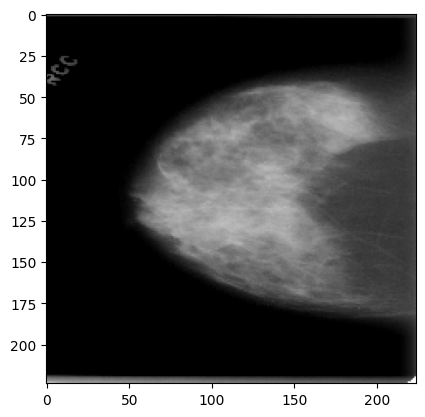

In [75]:
plt.imshow(train_images[10])
plt.show()

In [76]:
train_labels = to_categorical(train_labels, num_classes)
# test_labels  = to_categorical(test_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

In [77]:
from tensorflow.keras.applications import InceptionV3

In [78]:
# base_model = InceptionV3(weights=None, include_top=False)
# base_model.load_weights('/kaggle/input/inception_weights/other/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [79]:
# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.2

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(2, activation='softmax')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [80]:
#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.00001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 64
max_epochs = 50
num_iterations = 150

In [82]:
# Now, include the callback in your model.fit() call
history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    steps_per_epoch=num_iterations,
                    validation_data=(valid_images, valid_labels),
                    callbacks=[early_stopping])

Epoch 1/50
104/150 ━━━━━━━━━━━━━━━━━━━━ 25s 564ms/step - accuracy: 0.5474 - loss: 26.7152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 170s 533ms/step - accuracy: 0.5617 - loss: 26.6487 - val_accuracy: 0.5859 - val_loss: 26.1654
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7460 - loss: 25.7336 - val_accuracy: 0.5762 - val_loss: 25.4400
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8128 - loss: 24.8823 - val_accuracy: 0.5399 - val_loss: 24.8275
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.8894 - loss: 24.0108 - val_accuracy: 0.5514 - val_loss: 24.1720
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9312 - loss: 23.1663 - val_accuracy: 0.5810 - val_loss: 23.4497
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9625 - loss: 22.3339 - val_accuracy: 0.6602 - val_loss: 22.5606
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.9783 - loss: 21.5250 - val_accuracy: 0.7007 - val_loss: 21.6745
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9873 - los

In [83]:
model.save('public_dataset_colab.h5')

In [84]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [85]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [86]:
overall_train_loss     = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss       = np.mean(val_loss)
overall_val_accuracy   = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.9734633409976959
Overall Validation Accuracy: 0.7110036277770996


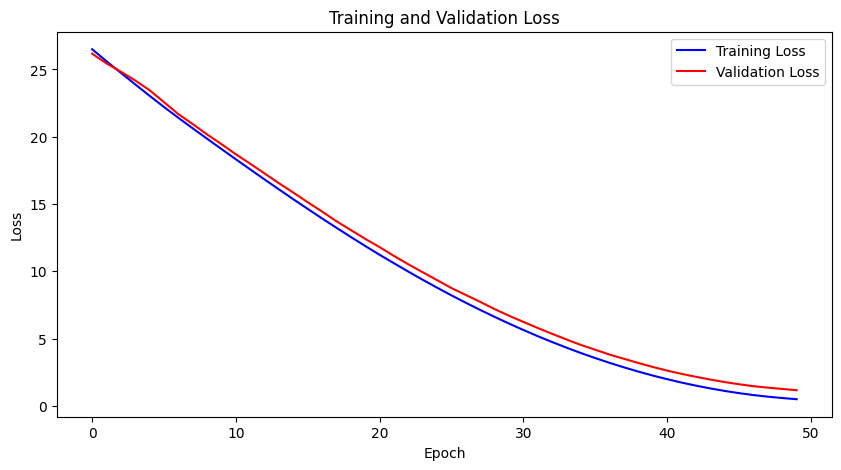

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss',   color='blue')
plt.plot(val_loss,   label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

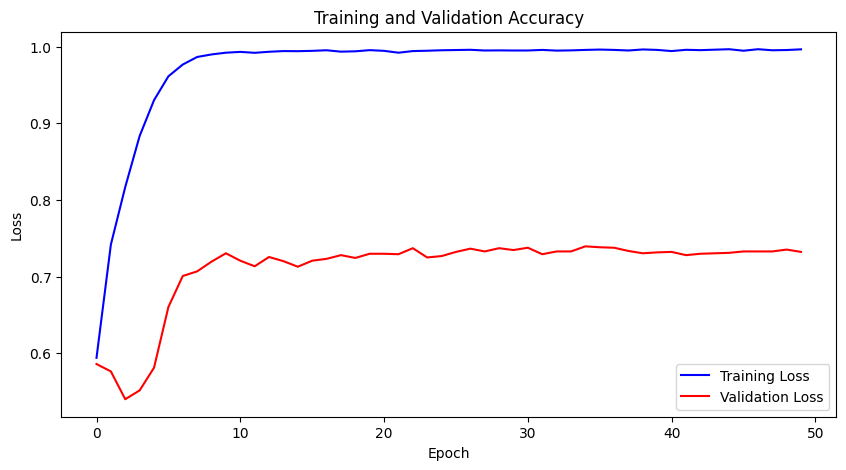

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Loss',   color='blue')
plt.plot(val_accuracy,   label='Validation Loss', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
del train_images, valid_images, train_labels, valid_labels
gc.collect()

18455